<a href="https://colab.research.google.com/github/MrBenjaminHolmes/Gravitational-Waves/blob/main/GWChallenges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gravitational Wave Open Data Challenges

In [1]:
!pip install -q lalsuite==7.25 scipy==1.12.0 gwpy==3.0.12 bilby==2.4.0 matplotlib==3.10.0 dynesty==2.1.5 corner==2.2.3 numpy==1.26.4 PyCBC==2.4.1

In [2]:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from IPython.utils import io
import matplotlib.pyplot as plt
import numpy
import os
import urllib
import h5py
import pandas as pd
import logging
logging.getLogger('bilby').setLevel(logging.ERROR)
import corner
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value
from scipy.signal import welch
#Bilby
import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.core.utils import SamplesSummary
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

# GW
import gwpy
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
from gwpy.signal import qtransform

# PyCBC
import pycbc
import pycbc.noise
import pycbc.psd
from pycbc.catalog import Merger
from pycbc.detector import Detector
from pycbc.events.ranking import newsnr
from pycbc.filter import (
    highpass,
    matched_filter,
    resample_to_delta_t,
    sigma
)
from pycbc.vetoes import power_chisq
from pycbc.frame import read_frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import (
    fd_approximants,
    get_td_waveform,
    get_fd_waveform,
    td_approximants
)

# Challenge 1


Identify a loud binary black hole signal in white, Gaussian noise.

* Use the data file `challenge1.gwf`. The channel name is `H1:CHALLENGE1`.
* The data are white, Gaussian noise containing a simulated BBH signal.

1. Load the data into memory. What are the sampling rate and duration of the data?
2. Plot the data in the time-domain.
3. Plot a spectrogram (or q-transform) of the data, and try to identify the signal.
4. What is the time of the merger?


Getting: https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/challengeData/challenge1.gwf
Sampling rate: 4096.0 Hz
Duration: 128.0 seconds


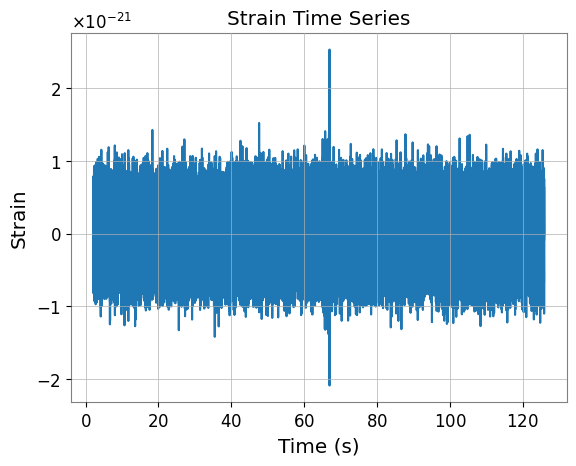

In [3]:
def get_file(fname):
    url = f"https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/challengeData/{fname}"
    urllib.request.urlretrieve(url, fname)
    print(f'Getting: {url}')

file_name = 'challenge1.gwf'
channel_name = "H1:CHALLENGE1"
start = 0
end = start + 128

get_file(file_name)


# Load and preprocess strain
ts = read_frame(file_name, channel_name, start, end)

sampling_rate = 1.0 / ts.delta_t
print(f"Sampling rate: {sampling_rate} Hz")

duration = ts.duration  # in seconds
print(f"Duration: {duration} seconds")

ts = ts.highpass_fir(15, 512)
ts = resample_to_delta_t(ts, 1.0/2048).crop(2, 2)

plt.figure()
plt.plot(ts.sample_times, ts.data)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Strain Time Series")
plt.show()


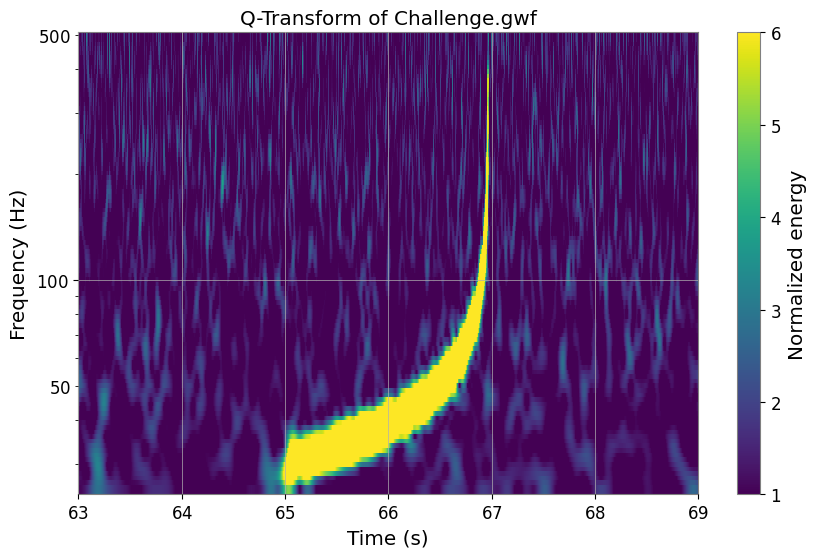

In [4]:
time, frequency, power = ts.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(4, 20), frange=(25, 500))
power_sqrt = power**0.5

plt.figure(figsize=(10, 6))
plt.pcolormesh(time, frequency, power_sqrt, vmin=1, vmax=6, shading = "auto")
plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Q-Transform of Challenge.gwf')
plt.xlim(65-2,65+4)
plt.colorbar(label='Normalized energy')
plt.show()

#Challenge 2

Signal in colored, Gaussian noise.

* Use the data file `challenge2.gwf`, with channel name `H1:CHALLENGE2`.
* The data contain a BBH signal with m1 = m2 = 30 solar masses, spin = 0.

1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)
2. Generate a time-domain template waveform using approximate `SEOBNRv4_opt`.
   with the same parameters as above. Plot this waveform.
3. Calculate a PSD of the data, and plot this on a log-log scale.
   Use axes ranging from 20 Hz up to the Nyquist frequency.
4. Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.
5. What is the matched filter SNR of the signal?

Getting: https://raw.githubusercontent.com/MrBenjaminHolmes/Gravitational-Waves/main/SampleData/challengeData/challenge2.gwf


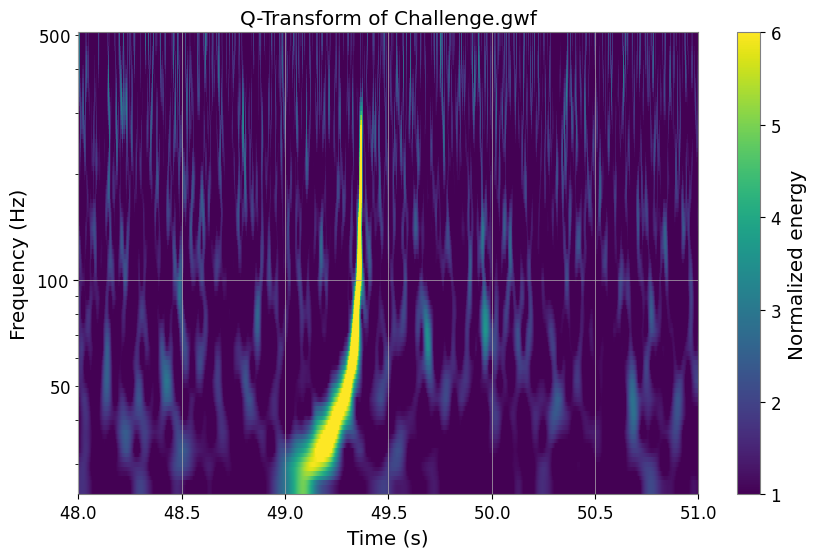

In [5]:
mass=30

file_name = 'challenge2.gwf'
channel_name = "H1:CHALLENGE2"
start = 0
end = start + 128

get_file(file_name)
ts = read_frame(file_name, channel_name, start, end)

#Condition data
ts = ts.highpass_fir(15, 512)
ts = resample_to_delta_t(ts, 1.0/2048).crop(2, 2)

# Q-transform
time, frequency, power = ts.whiten(4, 4).qtransform(
    .001, logfsteps=100, qrange=(4, 20), frange=(25, 500)
)
power_sqrt = power**0.5

plt.figure(figsize=(10, 6))
plt.pcolormesh(time, frequency, power_sqrt, vmin=1, vmax=6, shading="auto")
plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Q-Transform of Challenge.gwf')
plt.colorbar(label='Normalized energy')
plt.xlim(49 - 1, 49 + 2)
plt.show()

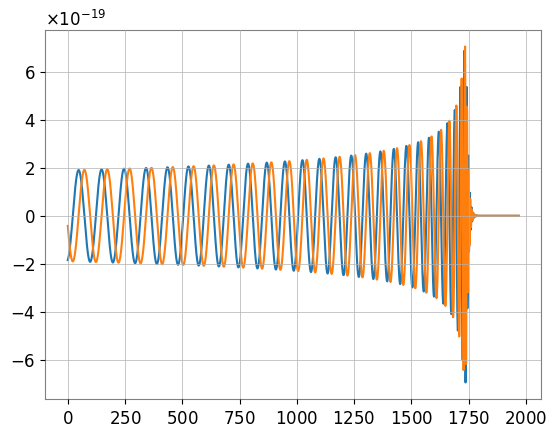

In [6]:
hp, hc = get_td_waveform(approximant="SEOBNRv4",
                         mass1=mass,
                         mass2=mass,
                         delta_t=ts.delta_t,
                         f_lower=20)

plt.plot(hp)
plt.plot(hc)
plt.show()

hp.resize(len(ts))

In [7]:
psd = ts.psd(4)
psd = interpolate(psd,  ts.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 *  ts.sample_rate),
                                  low_frequency_cutoff=15)

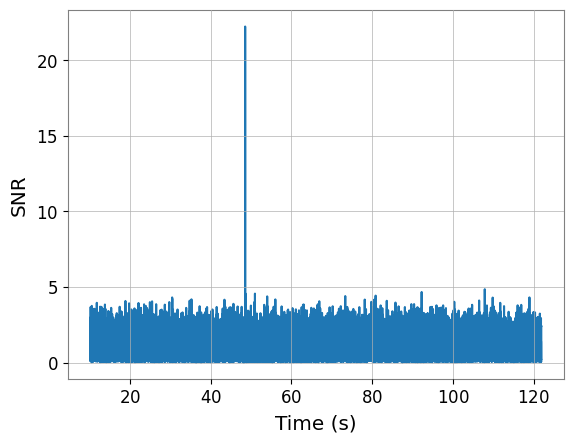

Peak SNR: (22.089138264372696+2.530312450324961j)


In [8]:
snr = matched_filter(hp,ts,
                      psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

plt.figure()
plt.plot(snr.sample_times, abs(snr))
plt.xlabel("Time (s)")
plt.ylabel("SNR")
plt.show()

maxIndex=  numpy.argmax(snr)
peak = snr.data[maxIndex]

print("Peak SNR:" , peak)

# Challenge 3

* Use the data file `challenge3.gwf` with channel `H1:CHALLENGE3`.
* These are real LIGO data from O2, though we've adjusted the time labels and
  added some simulated signals.
* The data contain a loud simulated signal with m1 = m2 = 10 solar masses.

1. What is the merger time of this signal?
2. What is the matched-filter SNR of this signal?

--2025-08-11 13:32:29--  https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.133
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256814830 (245M)
Saving to: ‘challenge3.gwf.3’

challenge3.gwf.3    100%[===================>] 244.92M  46.3MB/s    in 5.8s    

2025-08-11 13:32:35 (42.5 MB/s) - ‘challenge3.gwf.3’ saved [256814830/256814830]



Text(0.5, 0, 'Time (s)')

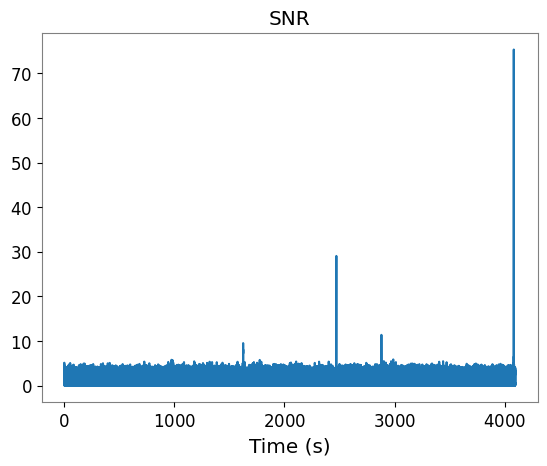

In [9]:
! wget https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf

strain = read_frame('challenge3.gwf', 'H1:CHALLENGE3')
strain = strain.highpass_fir(15, 512)
strain = resample_to_delta_t(strain, 1.0/2048).crop(2, 2)
psd = strain.psd(4)
psd = interpolate(psd, strain.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15)

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=10,
                     mass2=10,
                     delta_t=strain.delta_t,
                     f_lower=15)

hp.resize(len(strain))

snr = matched_filter(hp, strain,
                     psd=psd, low_frequency_cutoff=20)

plt.plot(snr.sample_times,abs(snr))
plt.title("SNR")
plt.grid(False)
plt.xlabel("Time (s)")

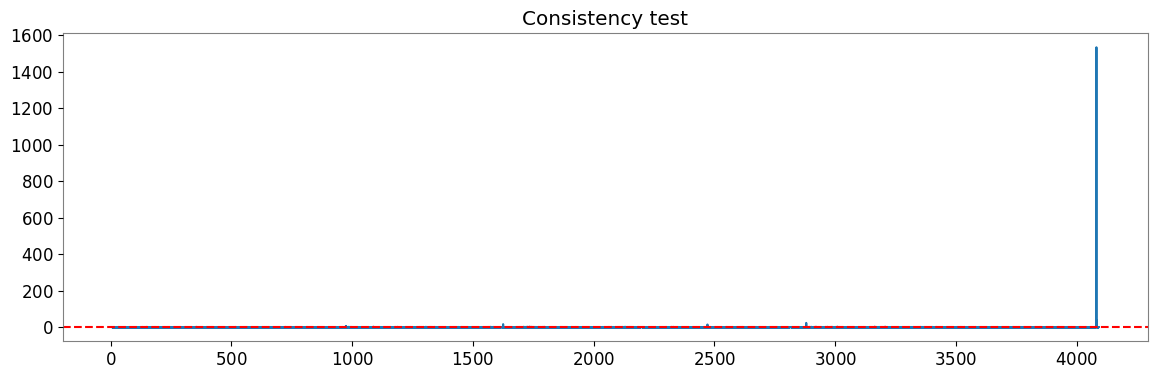

In [10]:
nbins = 26
chisq = power_chisq(hp, strain, nbins, psd, low_frequency_cutoff=20.0)
chisq = chisq.crop(5, 4)
dof = nbins * 2 - 2
chisq /= dof

plt.figure(figsize=[14, 4])
plt.plot(chisq.sample_times, chisq.data)
plt.axhline(y=1, color='red', linestyle='--', label='y = 1')
plt.grid()
plt.title("Consistency test")
plt.show()

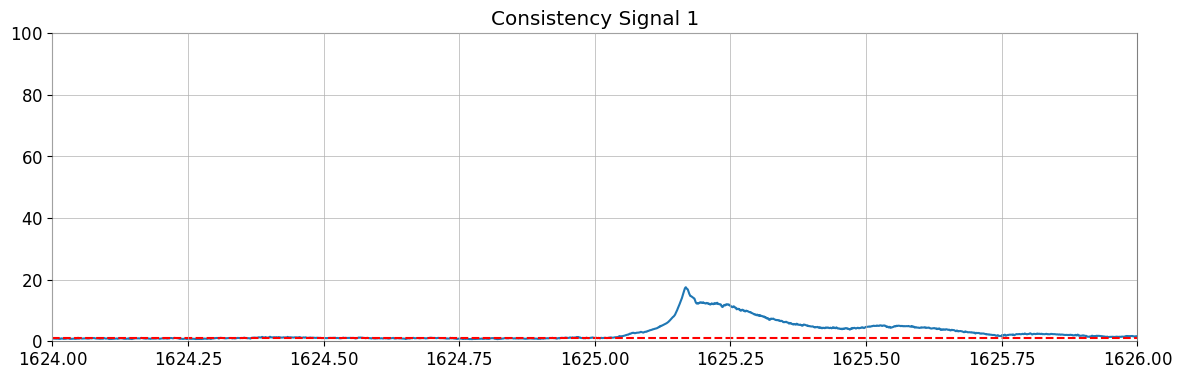

In [11]:
plt.figure(figsize=[14, 4])
plt.plot(chisq.sample_times, chisq.data)
plt.axhline(y=1, color='red', linestyle='--', label='y = 1')
plt.xlim(1624,1626)
plt.ylim(0,100)
plt.title("Consistency Signal 1")
plt.show()

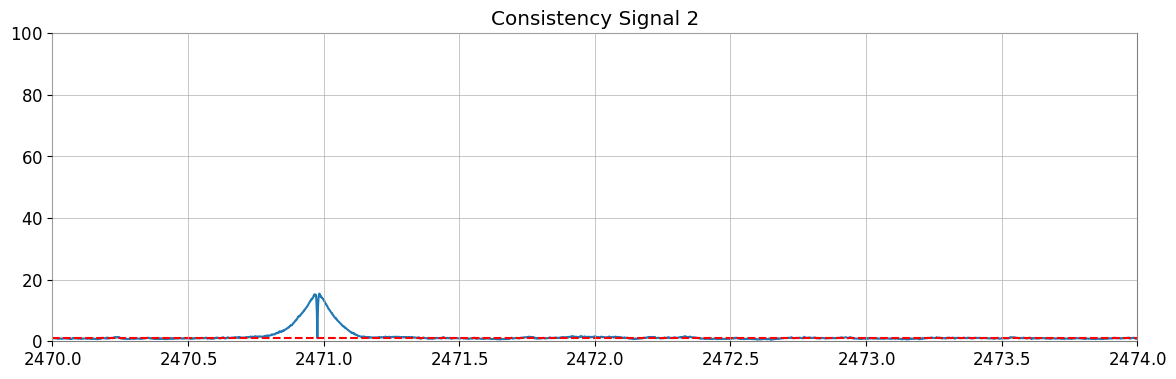

In [12]:
plt.figure(figsize=[14, 4])
plt.plot(chisq.sample_times, chisq.data)
plt.axhline(y=1, color='red', linestyle='--', label='y = 1')
plt.xlim(2470,2474)
plt.ylim(0,100)
plt.title("Consistency Signal 2")
plt.show()

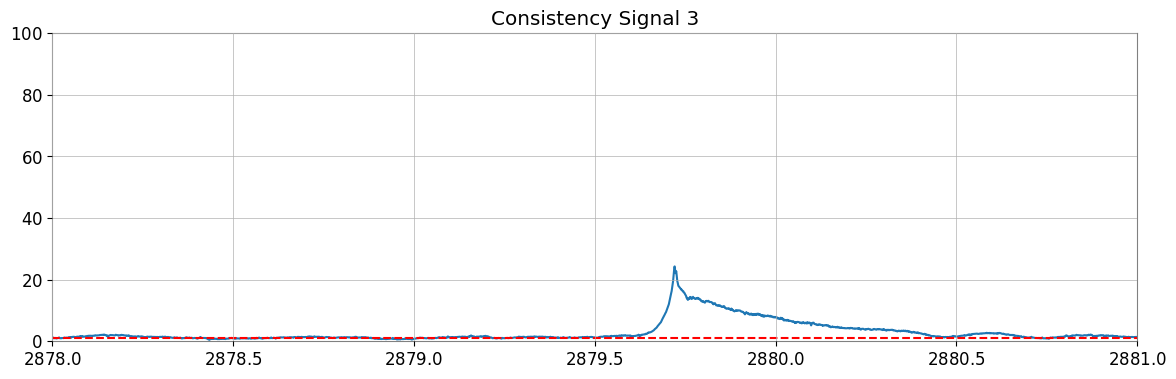

In [13]:
plt.figure(figsize=[14, 4])
plt.plot(chisq.sample_times, chisq.data)
plt.axhline(y=1, color='red', linestyle='--', label='y = 1')
plt.xlim(2878,2881)
plt.ylim(0,100)
plt.title("Consistency Signal 3")
plt.show()

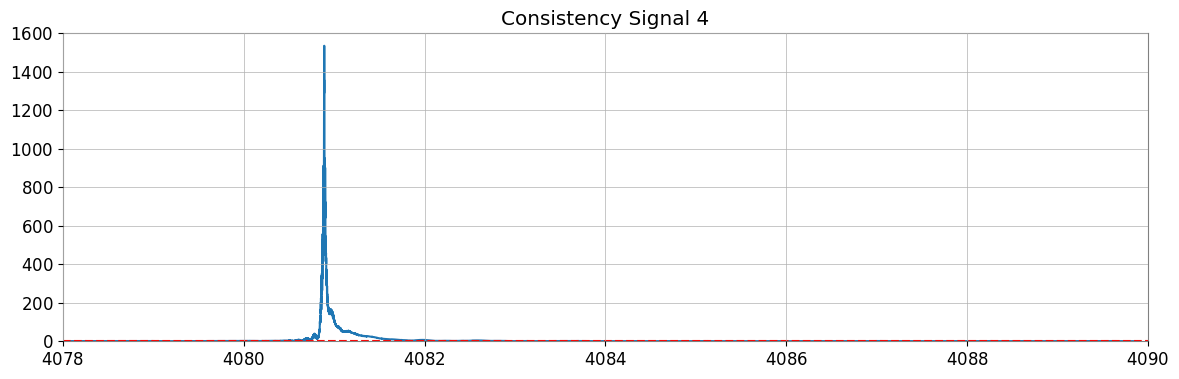

In [14]:
plt.figure(figsize=[14, 4])
plt.plot(chisq.sample_times, chisq.data)
plt.axhline(y=1, color='red', linestyle='--', label='y = 1')
plt.xlim(4078,4090)
plt.ylim(0,1600)
plt.title("Consistency Signal 4")
plt.show()

Peak Value: 29.06 at t = 2470.977 s


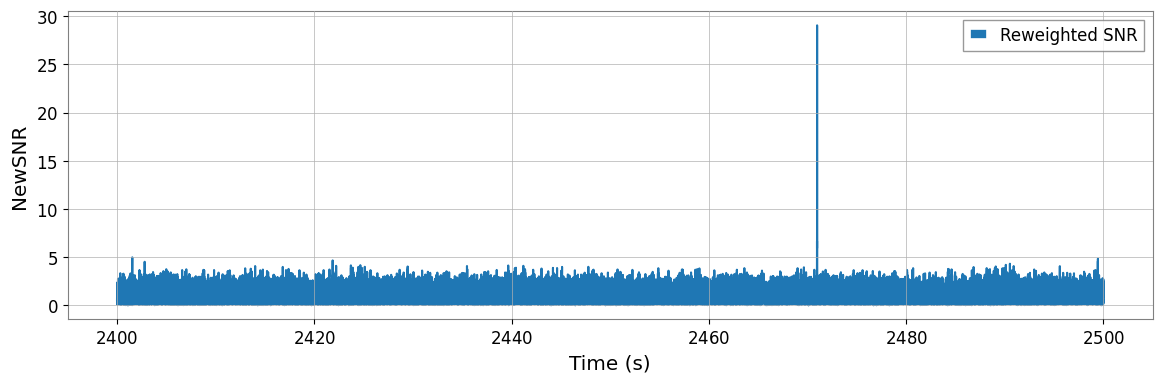

In [15]:
rho = abs(snr)
chi_r_sq = chisq.data


newSNR_array = newsnr(rho, chi_r_sq)

times = rho.sample_times.numpy()

t_low = 2400
t_high = 2500

mask = (times >= t_low) & (times <= t_high)

rho_cropped = rho.data[mask]
times_cropped = times[mask]
newSNR_cropped = newSNR_array[mask]

# Peak detection
peakIndex = numpy.argmax(newSNR_cropped)
peakValue = newSNR_cropped[peakIndex]
peakTime = times_cropped[peakIndex]

print(f"Peak Value: {peakValue:.2f} at t = {peakTime:.3f} s")

# Plot
plt.figure(figsize=(14,4))
plt.plot(times_cropped, newSNR_cropped, label="Reweighted SNR")
plt.xlabel("Time (s)")
plt.ylabel("NewSNR")
plt.grid(True)
plt.legend()
plt.show()